In [1]:
#setup
%pip install -q pandas numpy matplotlib scikit-learn

#Makes paths work if you just clone or pull the repo
import os
os.chdir('../')

Note: you may need to restart the kernel to use updated packages.


# Data 422: Data Exploration - DBSCAN Clustering

This notebook will cluster GHGEmissionIntesity into an alternative categorical variable we may use for our final model's prediction if our numerical predictions prove to be largely inaccurate.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

df = pd.read_csv('Data/Seattle_Building_Data_Cleaned.csv')

### Determining Optimal Parameters to Minimize Outliers

In [3]:
# determine best eps and min_sample for lowest number of outliers with at least 3 clusters
# NOTE: this nested loop takes a considerable amount of time to execute (approx. 20 min)

data = df["GHGEmissionsIntensity"].values.reshape(-1, 1)

min_noise = 10**5
best_eps = 0
best_min_sample = 0

for eps in np.arange(0.01, 1.01, 0.01):
    print("on eps: ", eps)
    for min_sample in range(100, 1217, 1):
        db = DBSCAN(eps=eps, min_samples=min_sample).fit(data)
        labels = db.labels_
        
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        num_noise = list(labels).count(-1)

        if (num_clusters >= 3) and (num_noise < min_noise):
            min_noise = num_noise
            best_eps = eps
            best_min_sample = min_sample

print("The lowest number of outliers is ", min_noise)
print("The associated eps: ", best_eps, " and min_sample: ", best_min_sample)

on eps:  0.01
on eps:  0.02
on eps:  0.03
on eps:  0.04
on eps:  0.05
on eps:  0.060000000000000005
on eps:  0.06999999999999999
on eps:  0.08
on eps:  0.09
on eps:  0.09999999999999999
on eps:  0.11
on eps:  0.12


KeyboardInterrupt: 

The lowest number of outliers is  740 <br>
The associated eps:  0.17  and min_sample:  414

### DBSCAN with Selected Parameters

In [161]:
data = df["GHGEmissionsIntensity"].values.reshape(-1, 1)

db = DBSCAN(eps=0.17, min_samples=414).fit(data)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 740


In [174]:
# function to map cluster labels in ascending order of GHG Intensity (was previously 1, 2, 0, -1, want 0, 1, 2, 3)
def relabel(i):
    if i == 1.0:
        return 0
    elif i == 2.0:
        return 1
    elif i == 0.0:
        return 2
    elif i == -1.0:
        return 3

# add new cluster labels to the df (called df2 now)
df2 = df.assign(GHGIntensityCluster=pd.Series(labels).apply(relabel))

df2.to_csv('Data/Seattle_Building_Clusters.csv', index=False)

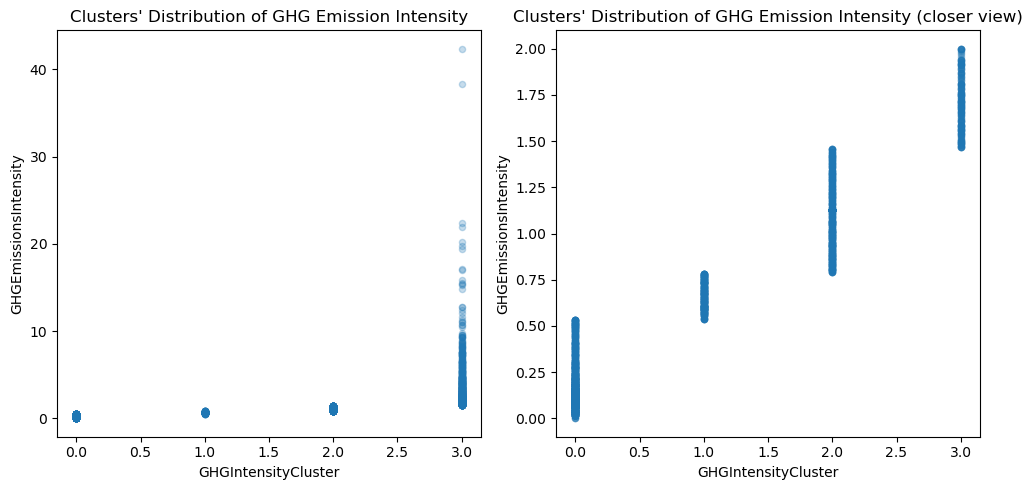

In [184]:
# plot the distribution of GHGEmissionIntensity in each cluster

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df2.plot(kind="scatter", alpha = 0.25, ax=axes[0], x = "GHGIntensityCluster", y = "GHGEmissionsIntensity")
axes[0].set_title("Clusters' Distribution of GHG Emission Intensity")

df2.loc[df2["GHGEmissionsIntensity"] <= 2, ].plot(kind="scatter", alpha = 0.25, ax=axes[1], x = "GHGIntensityCluster", y = "GHGEmissionsIntensity")
axes[1].set_title("Clusters' Distribution of GHG Emission Intensity (closer view)")

plt.tight_layout()

### Accessing the New Clusters' Range

In [176]:
for cluster in range(4):
    df2_cluster = df2.loc[df2["GHGIntensityCluster"] == cluster,]
    
    print("for cluster: ", cluster)
    print("size: ", len(df2_cluster["GHGEmissionsIntensity"]))
    print("min values is: ", min(df2_cluster["GHGEmissionsIntensity"]))
    print("max values is: ", max(df2_cluster["GHGEmissionsIntensity"]))

for cluster:  0
size:  1824
min values is:  0.0
max values is:  0.53
for cluster:  1
size:  358
min values is:  0.54
max values is:  0.78
for cluster:  2
size:  731
min values is:  0.79
max values is:  1.46
for cluster:  3
size:  740
min values is:  1.47
max values is:  42.35


For the 4 cluster groups made, we have: <br>
| Cluster Label | Size | Min | Max | Cluster Name |
| --- | --- | --- | --- | ---|
|0|1824|0|0.53|low|
|1|358|0.54|0.78|med|
|2|731|0.79|1.46|high|
|3|740|1.47|42.35|extreme high|

Then, with the table and the scatter plots provided, we may consider the intervals listed in the table (min - max) as the clusters. Note that cluster 3 is all the outliers of the dataset that DBSCAN did not cluster. However, since all the outliers lay above the rest of the points we may choose to make the outliers their own distinct cluster that we can simply call extreme high.

<b>Why we selected it over others</b> - DBSCAN is useful to create clusters with differing sizes and when there are many outliers (which GHGEmissionIntensity has). Unlike k-means, DBSCAN does not require a number of clusters instead automatically creating an appropriate number of clusters (in this case three).<br>

<b>How it's relevant to final project goals and objectives</b> - This clustering essientially creates out numerical response feature into a categorical repsonse. This allows us an alternative classification model if our regression model performs poorly.<br>

<b>What the results of the technique provided you with</b> - As seen in the table above, DBSCAN found 3 official clusters when our epsilon value (maximum distance between points to be considered "close") was set to 0.17 and our minimum sample value (min number of points "close" to a particular point to be a core point) was 414. The last "cluster" is DBSCAN's outliers who did not make it into a cluster. However, as the data is 1D, all true clusters partition the data sequentially, and all outliers are higher than the clusters, we can count the outliers its own cluster and call it extreme high.<br>

<b>Conclusions on how you can integrate the results and provide you with better insight on how you can achieve you final goals</b> - The clusters in conjunction with a decision tree can give us a different model to classify GHG Emission Intensity rather than predicting a value which may yield unsatisfactory results. Another thing to note is that we can use DBSCAN on other variables we may later want to classify to assist our model.